In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import operator
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from scipy.ndimage.measurements import label
%matplotlib inline

Your function returned a count of 834  cars and 3900  non-cars
of size:  (64, 64, 3)  and data type: float32


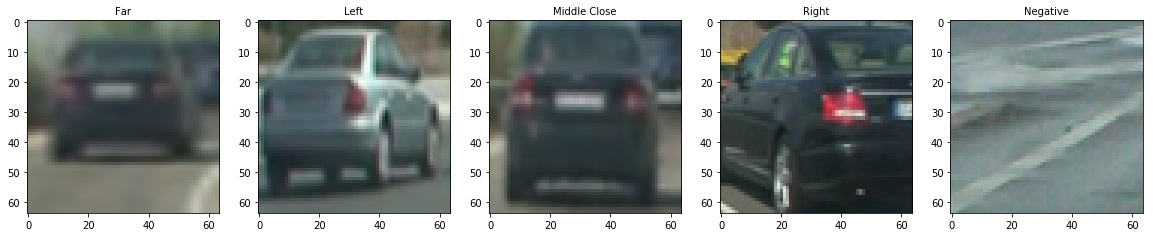

In [2]:
vehicles_far_file = '/Users/hiro99ishikawa/Desktop/vehicles-data/vehicles/GTI_Far/'
gti_vehicles_far = glob.glob(vehicles_far_file+'*.png')

vehicles_left_file = '/Users/hiro99ishikawa/Desktop/vehicles-data/vehicles/GTI_Left/'
gti_vehicles_left = glob.glob(vehicles_left_file+'*.png')

vehicles_middleclose_file = '/Users/hiro99ishikawa/Desktop/vehicles-data/vehicles/GTI_MiddleClose/'
gti_vehicles_middleclose = glob.glob(vehicles_middleclose_file+'*.png')

vehicles_right_file = '/Users/hiro99ishikawa/Desktop/vehicles-data/vehicles/GTI_Right/'
gti_vehicles_right = glob.glob(vehicles_right_file+'*.png')

kitti_vehicle_file = '/Users/hiro99ishikawa/Desktop/vehicles-data/vehicles/KITTI_extracted/'
kitti_vehicles = glob.glob(kitti_vehicle_file+'*.png')

non_vehicles_file = '/Users/hiro99ishikawa/Desktop/vehicles-data/non-vehicles/GTI/'
gti_non_vehicles = glob.glob(non_vehicles_file+'*.png')

kitti_nonvehicles_file = '/Users/hiro99ishikawa/Desktop/vehicles-data/non-vehicles/Extras/'
kitti_non_vehicles = glob.glob(kitti_nonvehicles_file+'*.png')

def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    img =  mpimg.imread(car_list[0])
    data_dict["image_shape"] = img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict

data_info = data_look(gti_vehicles_far, gti_non_vehicles)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(gti_vehicles_far))
notcar_ind = np.random.randint(0, len(gti_non_vehicles))

car_ind = 1

# Read in car / not-car images
car_image_far = mpimg.imread(gti_vehicles_far[car_ind])
car_image_left = mpimg.imread(gti_vehicles_left[car_ind])
car_image_middleclose = mpimg.imread(gti_vehicles_middleclose[car_ind])
car_image_right = mpimg.imread(gti_vehicles_right[car_ind])
notcar_image = mpimg.imread(gti_non_vehicles[notcar_ind])

# visualize undistortion
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,10))
ax1.imshow(car_image_far)
ax1.set_title('Far', fontsize=10)
ax2.imshow(car_image_left)
ax2.set_title('Left', fontsize=10)
ax3.imshow(car_image_middleclose)
ax3.set_title('Middle Close', fontsize=10)
ax4.imshow(car_image_right)
ax4.set_title('Right', fontsize=10)
ax5.imshow(notcar_image)
ax5.set_title('Negative', fontsize=10)

plt.show()

## Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images

In [3]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [4]:
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [6]:
def convert_color(img, conv='RGB'):
    if conv == 'RGB':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

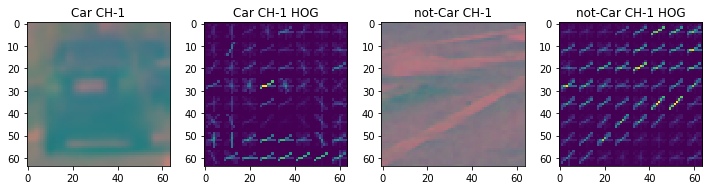

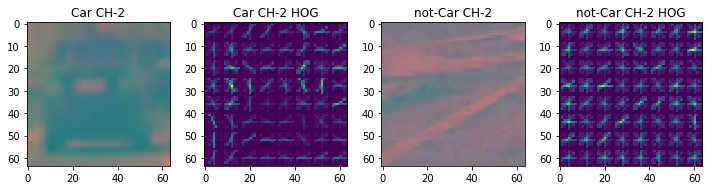

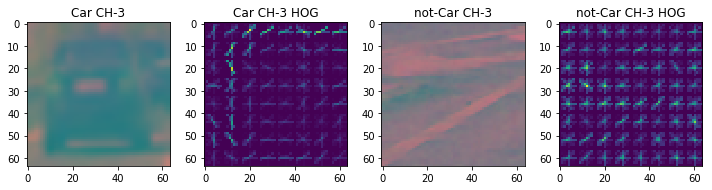

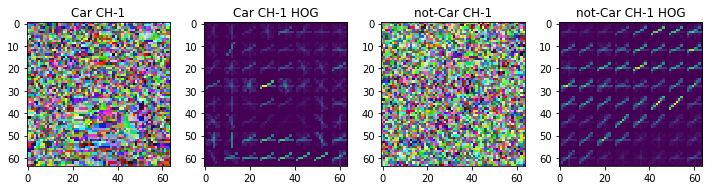

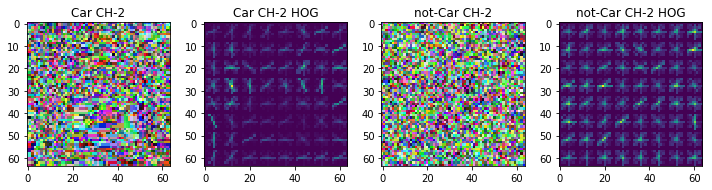

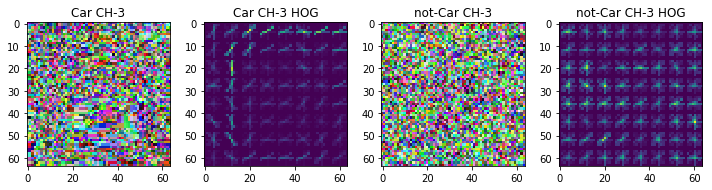

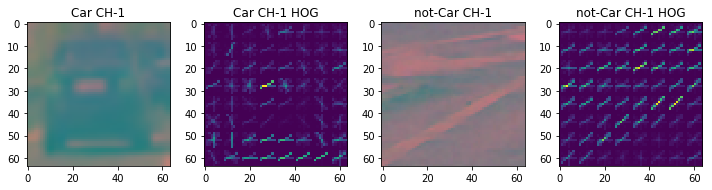

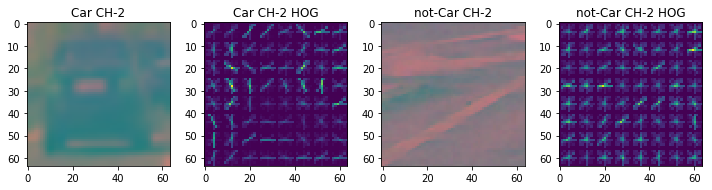

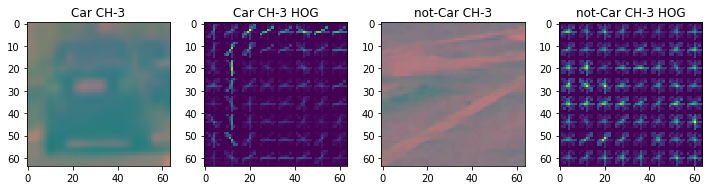

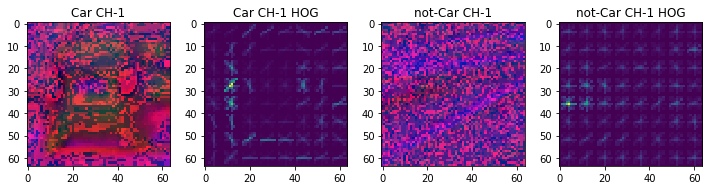

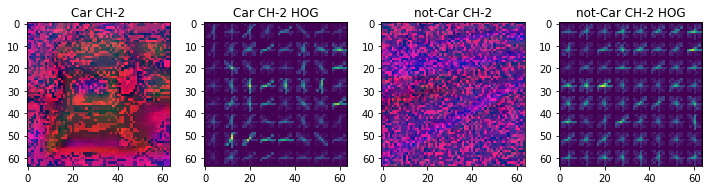

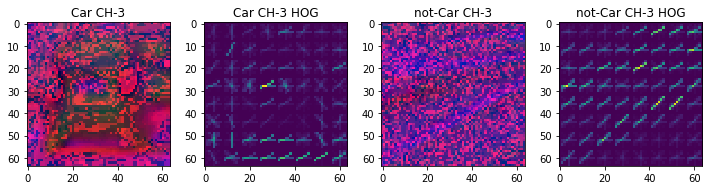

In [7]:
car_ind = 2
orient=8
pix_per_cell=8
cell_per_block=2

cspaces = ['RGB','LUV','YUV','HSV']

for cspace in cspaces:
    car_image = mpimg.imread(gti_vehicles_far[car_ind])
    notcar_image = mpimg.imread(gti_non_vehicles[notcar_ind])

    car_image = convert_color(car_image,conv=cspace)
    notcar_image = convert_color(notcar_image,conv=cspace)
    
    for i in range(3):
        hog_features_car, hog_image_car = get_hog_features(car_image[:,:,i], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
        hog_features_notcar, hog_image_notcar = get_hog_features(notcar_image[:,:,i], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
        fig = plt.figure()
        fig.set_figheight(10)
        fig.set_figwidth(10)
        plt.subplot(141)
        plt.imshow(car_image)
        plt.title('Car CH-'+str(i+1))
        plt.subplot(142)
        plt.imshow(hog_image_car)
        plt.title('Car CH-'+str(i+1)+' HOG')
        plt.subplot(143)
        plt.imshow(notcar_image)
        plt.title('not-Car CH-'+str(i+1))
        plt.subplot(144)
        plt.imshow(hog_image_notcar)
        plt.title('not-Car CH-'+str(i+1)+' HOG')
        plt.savefig('./output_images/hog_vis.png')
        fig.tight_layout()

In [8]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
#         hist_features = color_hist(feature_image, nbins=hist_bins) #, bins_range=hist_range
        # Call get_hog_features() with vis=False, feature_vec=True
        # Compute individual channel HOG features for the entire image
        ch1 = feature_image[:,:,0]
        ch2 = feature_image[:,:,1]
        ch3 = feature_image[:,:,2]
        hog_feat1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=True)
        hog_feat2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=True)
        hog_feat3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=True)
        hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
#       hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
#                         pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
#         features.append(np.concatenate((spatial_features, hist_features,hog_features)))
        features.append(np.concatenate((spatial_features, hog_features)))
        
    # Return list of feature vectors
    return features
#     return hog_features

In [9]:
# cars = sum([gti_vehicles_far, gti_vehicles_left, gti_vehicles_middleclose, gti_vehicles_right, kitti_vehicles],[])
# cars = sum([gti_vehicles_far, gti_vehicles_left, gti_vehicles_middleclose, gti_vehicles_right],[])
cars = sum([gti_vehicles_far, gti_vehicles_left, gti_vehicles_middleclose, gti_vehicles_right, kitti_vehicles[:2174]],[])
notcars = sum([gti_non_vehicles,kitti_non_vehicles[:1100]],[])
# notcars = gti_non_vehicles
print(len(cars))
print(len(notcars))

5000
5000


In [10]:
cspace='YUV'
spatial_size=(16,16)
hist_bins=64
hist_range=(0, 256)
orient = 12
pix_per_cell = 16
cell_per_block = 2

In [11]:
car_features = extract_features(cars, cspace=cspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=hist_range, orient=orient,
                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)

In [12]:
print(car_features[:2])
print(len(car_features))

[array([ 0.64353532,  0.61981869,  0.56650394, ...,  0.00631562,
        0.00397762,  0.00211601]), array([ 0.64412159,  0.62235498,  0.57214612, ...,  0.02170165,
        0.0047999 ,  0.00492582])]
5000


In [13]:
notcar_features = extract_features(notcars, cspace=cspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=hist_range, orient=orient,
                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)

In [14]:
print(notcar_features[:2])
print(len(notcar_features))

[array([ 0.49913436,  0.48826864,  0.49098629, ...,  0.01631395,
        0.02128049,  0.00513575]), array([ 0.68149412,  0.76190293,  0.75233924, ...,  0.01152316,
        0.00559158,  0.0057009 ])]
5000


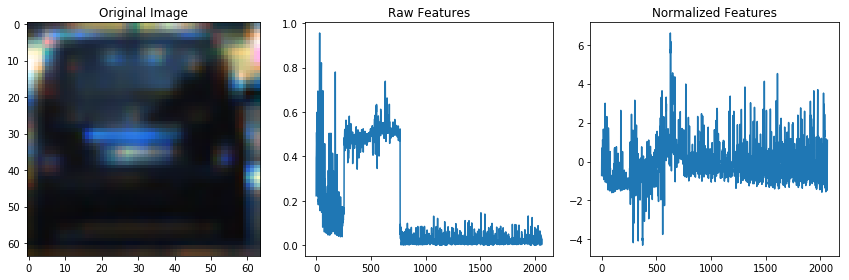

In [15]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))

# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

In [16]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

In [17]:
## Grid search

"""
tuned_parameters = [{'C': [1., 2.5, 5., 7.5]}]

scores = ['precision', 'recall']

# Use a linear SVC 
SVC = LinearSVC()

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LinearSVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
"""

'\ntuned_parameters = [{\'C\': [1., 2.5, 5., 7.5]}]\n\nscores = [\'precision\', \'recall\']\n\n# Use a linear SVC \nSVC = LinearSVC()\n\nfor score in scores:\n    print("# Tuning hyper-parameters for %s" % score)\n    print()\n\n    clf = GridSearchCV(LinearSVC(), tuned_parameters, cv=5,\n                       scoring=\'%s_macro\' % score)\n    clf.fit(X_train, y_train)\n\n    print("Best parameters set found on development set:")\n    print()\n    print(clf.best_params_)\n    print()\n    print("Grid scores on development set:")\n    print()\n    means = clf.cv_results_[\'mean_test_score\']\n    stds = clf.cv_results_[\'std_test_score\']\n    for mean, std, params in zip(means, stds, clf.cv_results_[\'params\']):\n        print("%0.3f (+/-%0.03f) for %r"\n              % (mean, std * 2, params))\n    print()\n\n    print("Detailed classification report:")\n    print()\n    print("The model is trained on the full development set.")\n    print("The scores are computed on the full evalu

In [18]:
# Naive training implementation
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(t2-t, 'Seconds to train SVC...')

# Check the score of the SVC
print('Train Accuracy of SVC = ', svc.score(X_train, y_train))
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))

# Check the prediction time for a single sample
t=time.time()
prediction = svc.predict(X_test[0].reshape(1, -1))
t2 = time.time()
print(t2-t, 'Seconds to predict with SVC')

14.593116998672485 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.981
0.0008847713470458984 Seconds to predict with SVC


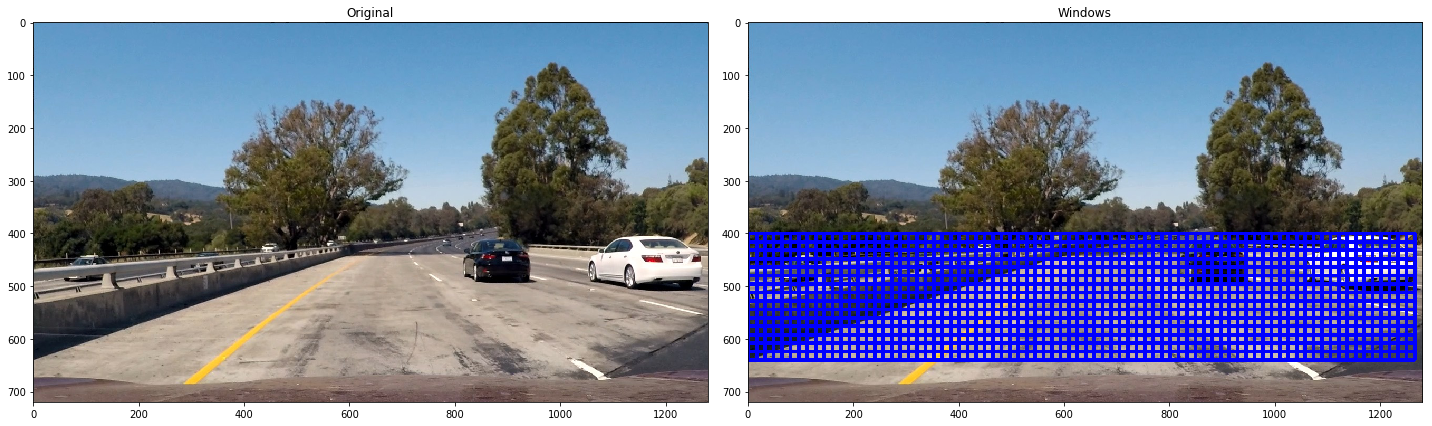

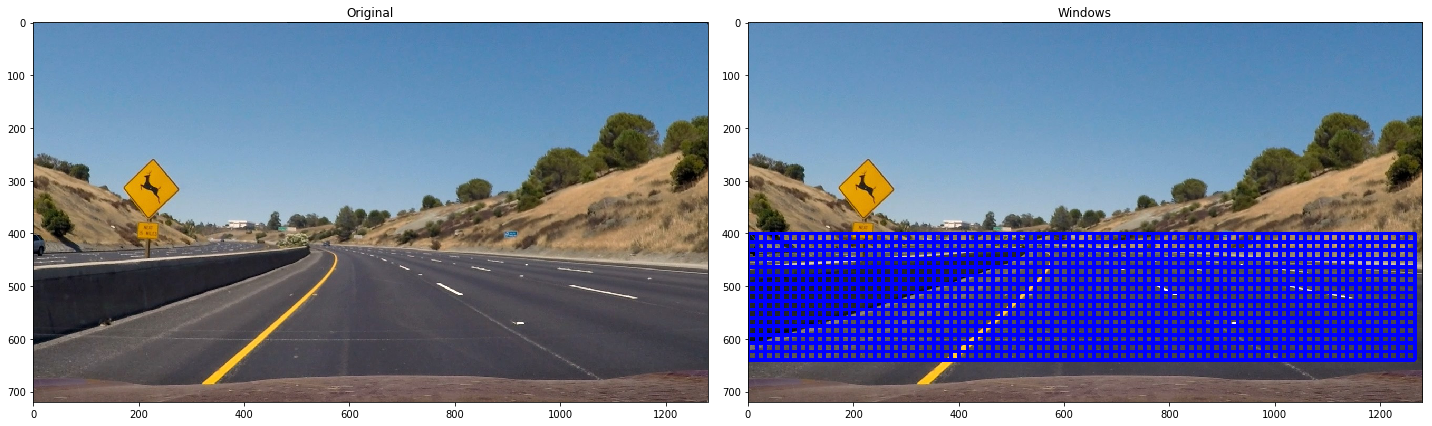

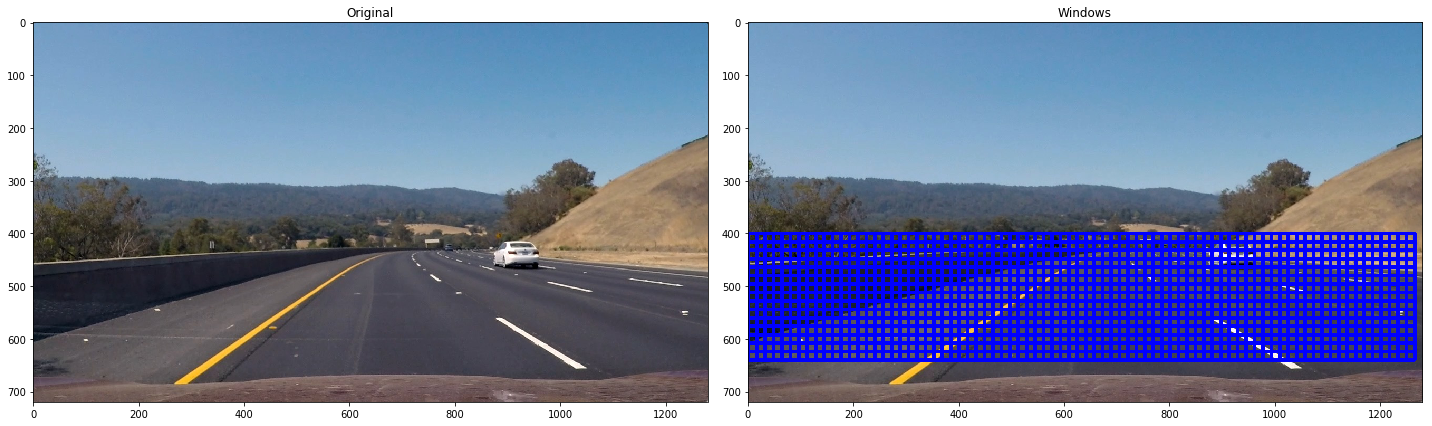

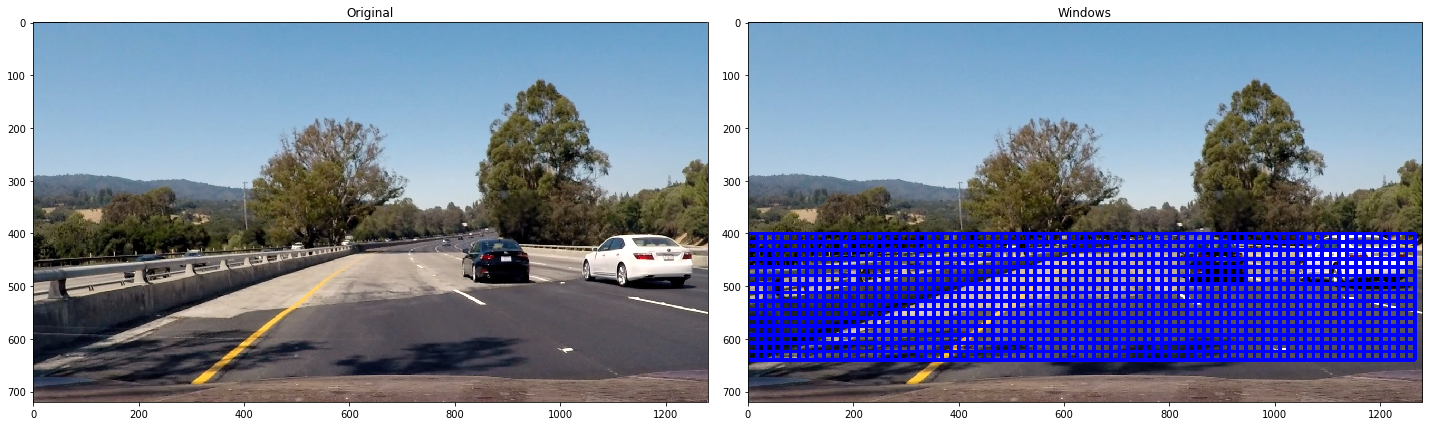

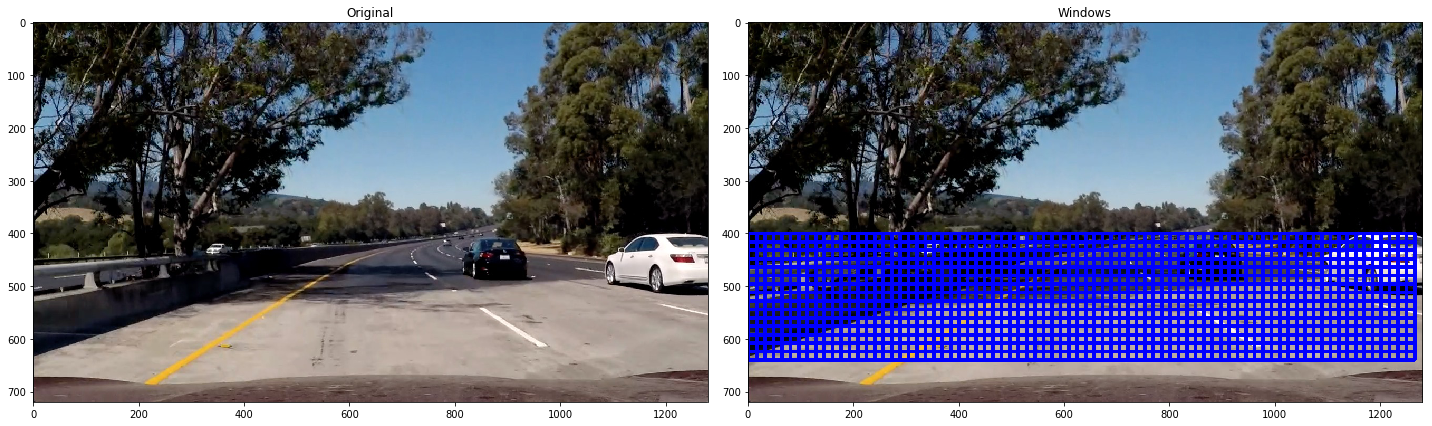

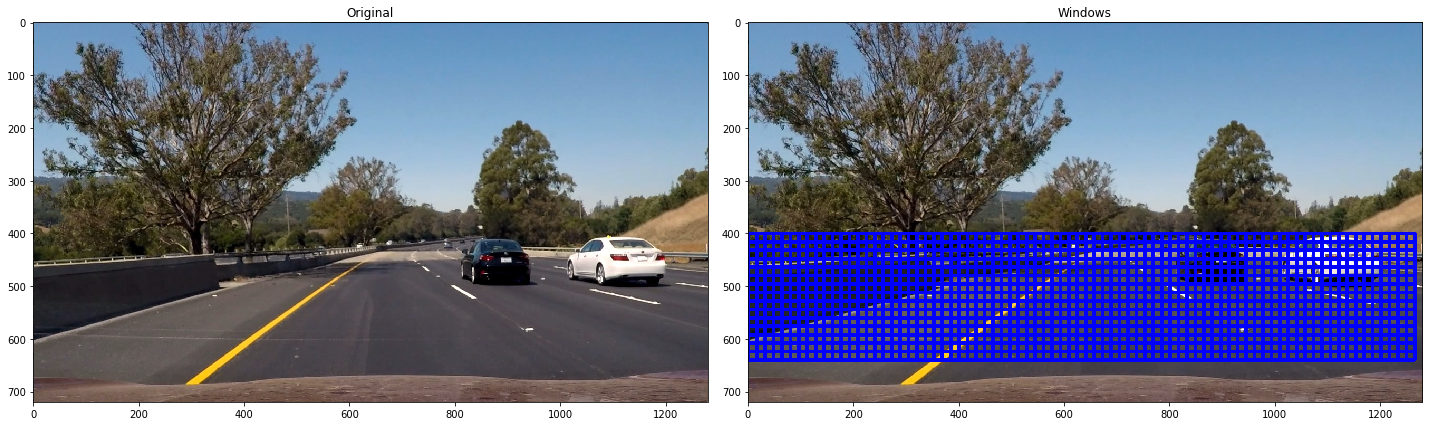

In [19]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def test_window(img, conv, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, decision_thres):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=conv)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 128
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    box_list = []
    
    for yb in range(nysteps):
        for xb in range(nxsteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
#             print(ypos)
#             ybottom = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
#             subimg = cv2.resize(ctrans_tosearch[ybottom:ybottom+window, xleft:xleft+window], (64,64))
           
            # Get color features
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
#             ybottom_draw = np.int(ybottom*scale)
            win_draw = np.int(window*scale)
            cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
#             cv2.rectangle(draw_img,(xbox_left, ybottom_draw+ystart),(xbox_left+win_draw,ybottom_draw-win_draw+ystart),(0,0,255),6) 
            box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
#             box_list.append(((xbox_left, ybottom_draw+ystart),(xbox_left+win_draw,ybottom_draw+win_draw+ystart)))
#         scale = scale+1.5
#         nblocks_per_window = (window // pix_per_cell)-1
#         nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
#         nysteps = (nyblocks - nblocks_per_window) // cells_per_step
            
    return draw_img, box_list
 
ystart = 400
ystop = 656
# ystop = 480
scale = 1.0
hist_bins = 64
spatial_size=(32, 32)
decision_thres = 3.0
conv = cspace
heat_thres = 1.0

for img_file in glob.glob('./test_images/*.jpg'):
#     img = mpimg.imread('./test_images/test.jpg')
    img = mpimg.imread(img_file)

    out_img, box_list = test_window(img, conv, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, decision_thres)

    fig = plt.figure()
    fig.set_figheight(20)
    fig.set_figwidth(20)
    plt.subplot(121)
    plt.imshow(img)
    plt.title('Original')
    plt.subplot(122)
    plt.imshow(out_img)
    plt.title('Windows')
    fig.tight_layout()

In [40]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, conv, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, decision_thres, scale_rate, window, cells_per_step):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=conv)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
#     window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
#     cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_list = []
    
    for yb in range(nysteps):
        for xb in range(nxsteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
#             hist_features = color_hist(subimg, nbins=hist_bins)
#             stack = np.hstack((spatial_features, hist_features, hog_features))
            stack = np.hstack((spatial_features, hog_features))
#             stack = np.concatenate((spatial_features, hist_features, hog_features))
#             print(stack.shape)
            stack_r = stack.reshape(1, -1)
#             print(stack.shape)
            # Scale features and make a prediction
            test_features = X_scaler.transform(stack_r)
#             test_features = X_scaler.transform(hog_features)
#             test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
#             test_prediction = svc.predict(test_features)
            decision = svc.decision_function(test_features)
            test_prediction = np.zeros_like(decision)
            test_prediction[(decision >= decision_thres)] = 1
        
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(50,50,255),4)
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(50,50,255),-200) 
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
        scale = scale + scale_rate
            
    return draw_img, box_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (50,50,255), 5)
    # Return the image
    return img


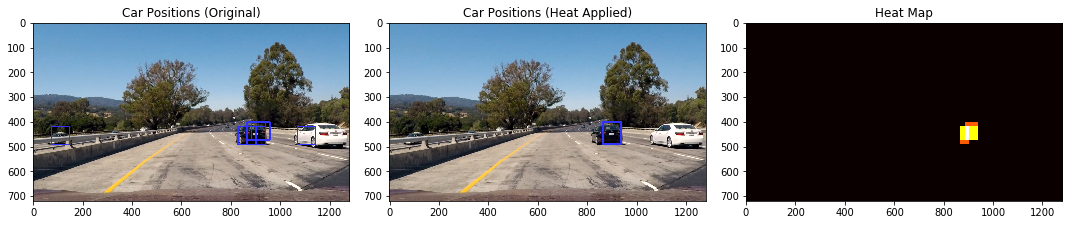

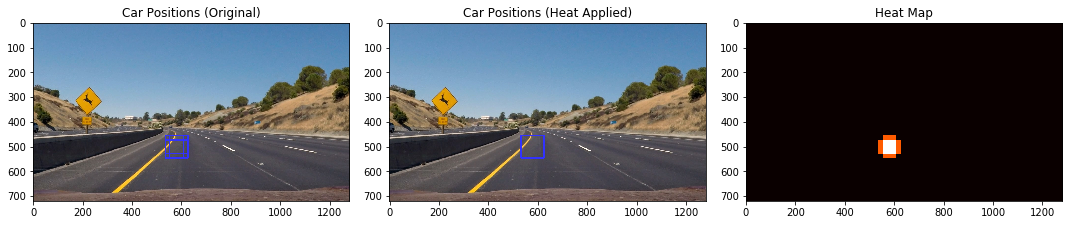

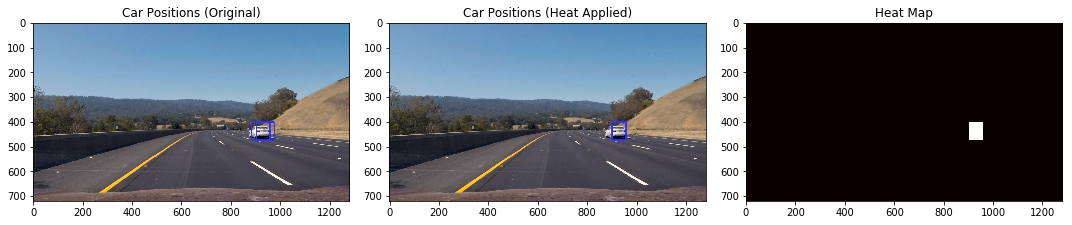

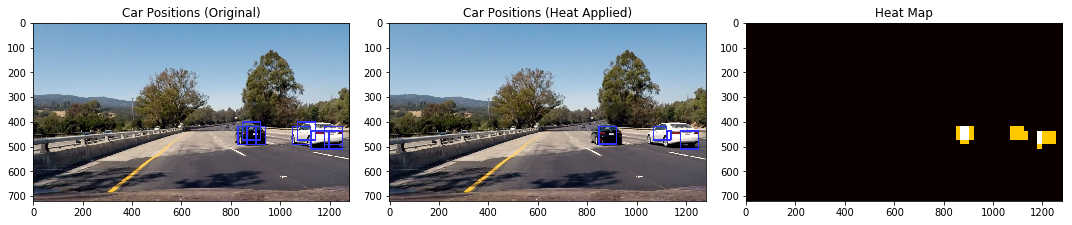

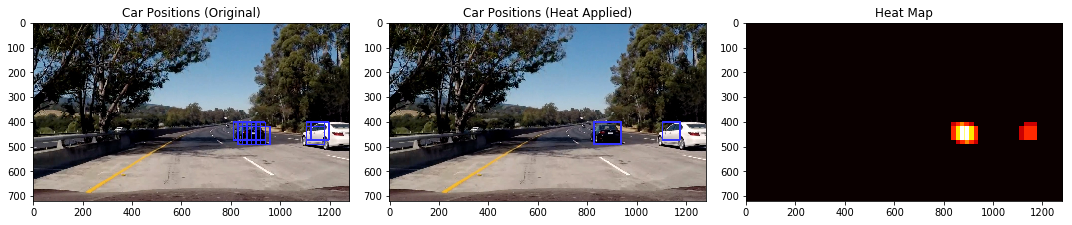

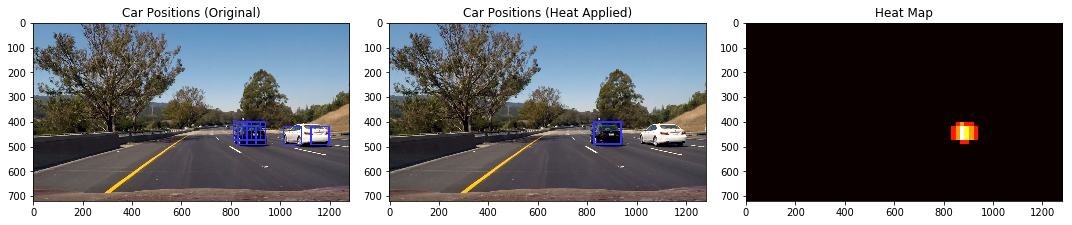

In [41]:
ystart = 400
ystop = 656
scale = 1.15
hist_bins = 64
spatial_size=(16, 16)
decision_thres = 3.0
conv = cspace
heat_thres = 1.0
scale_rate = 0.0
window = 64
cells_per_step = 1

for img_file in glob.glob('./test_images/*.jpg'):
#     img = mpimg.imread('./test_images/test.jpg')
    img = mpimg.imread(img_file)

    out_img, box_list = find_cars(img, conv, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, decision_thres, scale_rate, window, cells_per_step)

    # Read in image similar to one shown above 
    image = mpimg.imread(img_file)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,heat_thres)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    plt.subplot(131)
    plt.imshow(out_img)
    plt.title('Car Positions (Original)')
    plt.subplot(132)
    plt.imshow(draw_img)
    plt.title('Car Positions (Heat Applied)')
    plt.subplot(133)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()


[[((864, 400), (937, 473)), ((883, 400), (956, 473)), ((73, 418), (146, 491)), ((827, 418), (900, 491)), ((864, 418), (937, 491)), ((1067, 418), (1140, 491))], [((533, 455), (606, 528)), ((552, 455), (625, 528)), ((533, 473), (606, 546)), ((552, 473), (625, 546))], [((883, 400), (956, 473)), ((901, 400), (974, 473))], [((846, 400), (919, 473)), ((1067, 400), (1140, 473)), ((827, 418), (900, 491)), ((864, 418), (937, 491)), ((1048, 418), (1121, 491)), ((1177, 418), (1250, 491)), ((1122, 436), (1195, 509)), ((1177, 436), (1250, 509))], [((809, 400), (882, 473)), ((827, 400), (900, 473)), ((846, 400), (919, 473)), ((864, 400), (937, 473)), ((1104, 400), (1177, 473)), ((1122, 400), (1195, 473)), ((827, 418), (900, 491)), ((846, 418), (919, 491)), ((864, 418), (937, 491)), ((883, 418), (956, 491)), ((1104, 418), (1177, 491))], [((809, 400), (882, 473)), ((846, 400), (919, 473)), ((864, 400), (937, 473)), ((827, 418), (900, 491)), ((864, 418), (937, 491)), ((1011, 418), (1084, 491)), ((1122,

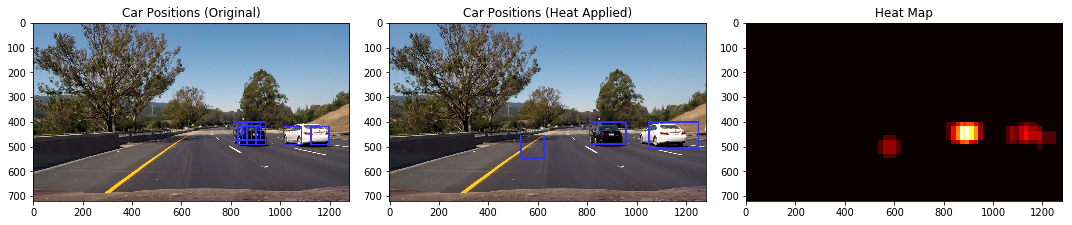

In [42]:
ystart = 400
ystop = 656
scale = 1.15
hist_bins = 64
spatial_size=(16, 16)
decision_thres = 3.0
conv = cspace
heat_thres = 1.0
scale_rate = 0.0
window = 64
cells_per_step = 1

box_lists = []

for img_file in glob.glob('./test_images/*.jpg'):
#     img = mpimg.imread('./test_images/test.jpg')
    img = mpimg.imread(img_file)

    out_img, box_list = find_cars(img, conv, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, decision_thres, scale_rate, window, cells_per_step)
    box_lists.append(box_list)

    if len(box_lists) >=6:
        flattened = []
        # Read in image similar to one shown above 
        image = mpimg.imread(img_file)
        heat = np.zeros_like(image[:,:,0]).astype(np.float)

        # flatten the box lists
        flattened = [val for sublist in box_lists for val in sublist]
        print(box_lists)
        print(flattened)
        
        # Add heat to each box in box list
#         heat = add_heat(heat,box_list)
        heat = add_heat(heat,flattened)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,heat_thres)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)

        fig = plt.figure()
        fig.set_figheight(15)
        fig.set_figwidth(15)
        plt.subplot(131)
        plt.imshow(out_img)
        plt.title('Car Positions (Original)')
        plt.subplot(132)
        plt.imshow(draw_img)
        plt.title('Car Positions (Heat Applied)')
        plt.subplot(133)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()
        


In [43]:
box_lists = []

def process_image(img):
    original_img = np.copy(img)
    out_img, box_list = find_cars(img, conv, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, decision_thres, scale_rate, window, cells_per_step)
    box_lists.append(box_list)
    # append the box list of the frame
    if len(box_lists) >= 6:
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        flattened = [val for sublist in box_lists for val in sublist]
        heat = add_heat(heat, flattened)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,heat_thres)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
        
        # remove the box list
        box_lists.pop(0)
        
        return draw_img
    else:
        return original_img

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_output = 'detect.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(15,50)
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))